In [1]:
import sys
import os

# Thêm đường dẫn vào sys.path
sys.path.append('/kaggle/input/resfusionmodel')

In [2]:
import sys
sys.argv = sys.argv[:1]  # Loại bỏ đối số '-f' của Jupyter

## set up datamodule


In [3]:
# https://github.com/IGITUGraz/WeatherDiffusion
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import Normalize
import numpy as np
import pytorch_lightning as pl




##################################################################
train_transform = A.Compose([
    A.RandomCrop(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2()],
    additional_targets={'gt_image': 'image'},
)

test_transform = A.Compose([
    Normalize(mean=(0, 0, 0), std=(1, 1, 1)),
    ToTensorV2()],
    additional_targets={'gt_image': 'image'},
)
##################################################################


import os
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

class RaindropDataset(Dataset):
    def __init__(self, root_dir, subset="DayRainDrop_Train", transform=None):
        """
        Initialize the dataset.
        :param root_dir: Root directory of the dataset
        :param subset: The dataset subset ('train', 'test_a')
        :param transform: Transformations to apply to the data
        """
        self.root_dir = root_dir
        self.subset = subset
        self.transform = transform
        
        subset_path = os.path.join(root_dir, subset)
        drop_path = os.path.join(subset_path, "Drop")
        clear_path = os.path.join(subset_path, "Clear")
        if os.path.exists(drop_path) and os.path.exists(clear_path):
            self.img_dir = drop_path
            self.gt_dir = clear_path
            
            self.img_names = []
            for folder in os.listdir(drop_path):
                folder_path = os.path.join(drop_path, folder)
                if os.path.isdir(folder_path):  # Check if it's a folder
                    images = sorted([img for img in os.listdir(folder_path) if img.lower().endswith(('jpg', 'png'))])
                    if images:  # Ensure there is at least one image
                        self.img_names.append(os.path.join(folder_path, images[0]))  # Take the first image
            self.img_names.sort()
            
            self.gt_names = []
            for folder in os.listdir(clear_path):
                folder_path = os.path.join(clear_path, folder)
                if os.path.isdir(folder_path):  # Check if it's a folder
                    images = sorted([img for img in os.listdir(folder_path) if img.lower().endswith(('jpg', 'png'))])
                    if images:  # Ensure there is at least one image
                         self.gt_names.append(os.path.join(folder_path, images[0]))  # Take the first image
            self.gt_names.sort()
        else:
            # Handle case where images are directly in the folder (e.g., for testing)
            self.img_dir = subset_path
            self.img_names = sorted(os.listdir(subset_path))
            self.gt_dir = None
            self.gt_names = None
    
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        
        if self.gt_dir:
            gt_name = self.gt_names[idx]
            gt_path = os.path.join(self.gt_dir, gt_name)
            gt = Image.open(gt_path).convert("RGB")
        else:
            gt = image.copy()  # Gán gt là chính image nếu không có ground truth
        
        # Resize images to be multiples of 16 for whole-image restoration
        wd_new, ht_new = image.size
        if ht_new > wd_new and ht_new > 1024:
            wd_new = int(np.ceil(wd_new * 1024 / ht_new))
            ht_new = 1024
        elif ht_new <= wd_new and wd_new > 1024:
            ht_new = int(np.ceil(ht_new * 1024 / wd_new))
            wd_new = 1024
        wd_new = int(16 * np.ceil(wd_new / 16.0))
        ht_new = int(16 * np.ceil(ht_new / 16.0))
        
        image = image.resize((wd_new, ht_new))
        gt = gt.resize((wd_new, ht_new))
        
        # Convert PIL images to NumPy arrays
        image = np.array(image)
        gt = np.array(gt)
        
        if self.transform:
            augmented = self.transform(image=image, gt_image=gt)
            image = augmented['image']
            gt = augmented['gt_image']
        
        return image, gt




class RaindropDataModule(pl.LightningDataModule):
    def __init__(self, root_dir: str = "/kaggle/input/ntire2025", batch_size=1, pin_mem=True, num_workers=4):
        super().__init__()
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.pin_mem = pin_mem
        self.num_workers = num_workers

    '''
    setup 方法创建Dataset对象，对不同数据集指定预处理方法
    '''

    def setup(self, stage: str):
        # Assign train/val dataloader for use in dataloaders
        if stage == "fit":
            self.train_dataset = RaindropDataset(root_dir=self.root_dir, subset="DayRainDrop_Train", transform=train_transform)
            self.val_dataset = RaindropDataset(root_dir=self.root_dir, subset="DayRainDrop_Train", transform=test_transform)
        # Assign test dataset for use in dataloader(s)
        if stage == "validate":
            self.val_dataset = RaindropDataset(root_dir=self.root_dir, subset="DayRainDrop_Train", transform=test_transform)
        if stage == "test":
            self.test_dataset = RaindropDataset(root_dir=self.root_dir, subset="/kaggle/input/ntire2025/RainDrop/RainDrop", transform=test_transform)

    # 以下方法创建不同阶段的数据加载器
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, shuffle=True, drop_last=True,
                                           batch_size=self.batch_size, pin_memory=self.pin_mem,
                                           num_workers=self.num_workers, persistent_workers=True)

    # batch_size must be 1 because size is different
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, shuffle=False, drop_last=False,
                                           batch_size=1, pin_memory=self.pin_mem,
                                           num_workers=self.num_workers, persistent_workers=True)

    # batch_size must be 1 because size is different
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, shuffle=False, drop_last=False,
                                           batch_size=1, pin_memory=self.pin_mem,
                                           num_workers=self.num_workers, persistent_workers=True)



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


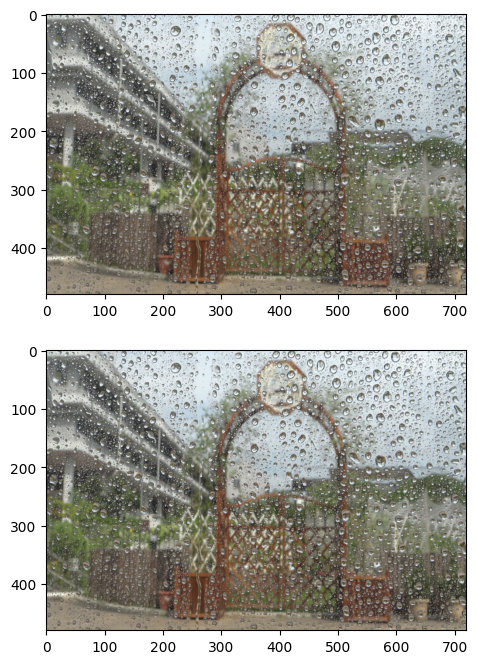

In [4]:
def visualize(image, mask, original_image=None, original_gt=None):
    fontsize = 18

    if original_image is None and original_gt is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))
        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_gt)
        ax[1, 0].set_title('Original gt', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed gt', fontsize=fontsize)
        
my_dataset = RaindropDataset(root_dir='/kaggle/input/ntire2025',subset='/kaggle/input/ntire2025/RainDrop/RainDrop')
input,target= my_dataset.__getitem__(0)


# 展示图像和掩码
visualize(input,target)
plt.show()

## inference


In [5]:
""" Test the resfusion restore module """
import pytorch_lightning as pl
from argparse import ArgumentParser
from pytorch_lightning import Trainer
from datamodule import LOLDataModule
from model.denoising_module import RDDM_Unet, DiT_models
from model import GaussianResfusion_Restore
from variance_scheduler import LinearProScheduler, CosineProScheduler
import torch
import time


def main(args):
    # 设定随机种子以及一些因素，用来控制实验结果
    if args.set_float32_matmul_precision_high:
        torch.set_float32_matmul_precision('high')
    if args.set_float32_matmul_precision_medium:
        torch.set_float32_matmul_precision('medium')

    pl.seed_everything(args.seed, workers=True)

    # 数据集的选择
    if args.dataset == 'LOL':
        data_module = LOLDataModule(root_dir=args.data_dir, batch_size=args.batch_size, pin_mem=args.pin_mem,
                                    num_workers=args.num_workers)
    elif args.dataset == 'Raindrop':
        data_module = RaindropDataModule(root_dir=args.data_dir, batch_size=args.batch_size, pin_mem=args.pin_mem,
                                         num_workers=args.num_workers)
    else:
        raise ValueError("Wrong dataset type !!!")

    # 噪声调度器的选择
    if args.noise_schedule == 'LinearPro':
        variance_scheduler = LinearProScheduler(T=args.T)
    elif args.noise_schedule == 'CosinePro':
        variance_scheduler = CosineProScheduler(T=args.T)
    else:
        raise ValueError("Wrong variance scheduler type !!!")

    # 去噪模型的选择
    if args.denoising_model == 'RDDM_Unet':
        denoising_model = RDDM_Unet(
            dim=args.dim,
            out_dim=args.n_channels,
            channels=args.n_channels,
            input_condition=True,
            input_condition_channels=args.n_channels,
            resnet_block_groups=args.resnet_block_groups
        )
    elif args.denoising_model in DiT_models:
        denoising_model = DiT_models[args.denoising_model](
            input_size=args.input_size,
            channels=args.n_channels,
            input_condition=True,
            input_condition_channels=args.n_channels,
        )
    else:
        raise ValueError("Wrong denoising_model type !!!")

    resfusion_restore_model = GaussianResfusion_Restore.load_from_checkpoint(
        checkpoint_path=args.model_ckpt,
        denoising_module=denoising_model,
        variance_scheduler=variance_scheduler,
        mode=args.mode
    )
    # test the model
    trainer = Trainer(
        devices=args.device,
        num_nodes=1,
        logger=True,
        default_root_dir=args.log_dir,
        deterministic='warn',
        precision=args.precision,
        enable_model_summary=False
    )
    start_time=time.time()
    trainer.test(model=resfusion_restore_model, datamodule=data_module)
    print(time.time()-start_time)


if __name__ == '__main__':
    parser = ArgumentParser('Test the resfusion_restore module')
    # Accuracy control
    parser.add_argument('--set_float32_matmul_precision_high', action='store_true')
    parser.set_defaults(set_float32_matmul_precision_high=False)
    parser.add_argument('--set_float32_matmul_precision_medium', action='store_true')
    parser.set_defaults(set_float32_matmul_precision_medium=False)

    # Basic Test Control
    parser.add_argument('--batch_size', default=4, type=int)
    parser.add_argument('--num_workers', default=4, type=int)
    parser.add_argument('--pin_mem', default=True, type=bool)
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--precision', default='32', type=str)

    # Hyperparameters
    parser.add_argument('--n_channels', default=3, type=int)
    parser.add_argument('--noise_schedule', default='LinearPro', type=str)
    parser.add_argument('--T', default=12, type=int)

    # Denoising Model Hyperparameters
    parser.add_argument('--denoising_model', default='RDDM_Unet', type=str)
    parser.add_argument('--mode', default='epsilon', type=str)
    parser.add_argument('--model_ckpt', default='/kaggle/input/resfusion-with-pseudo-code/lightning_logs/version_0/checkpoints/best-epoch=81-val_SSIM=0.978.ckpt', type=str)
    # RDDM_Unet(if used)
    parser.add_argument('--dim', default=64, type=int)
    parser.add_argument('--resnet_block_groups', default=8, type=int)

    # DiT(if used) or DDIM_Unet(if used)
    parser.add_argument('--input_size', default=256, type=int)

    # Test Info
    parser.add_argument('--dataset', default='Raindrop', type=str)
    parser.add_argument('--device', default=1, type=int)
    parser.add_argument('--data_dir', default='/kaggle/input/ntire2025', type=str)
    parser.add_argument('--log_dir', default='/kaggle/working/test', type=str)

    args = parser.parse_args()

    main(args)

acc point: 5


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_PSNR         │    22.362512588500977     │
└───────────────────────────┴───────────────────────────┘

2383.1319377422333


## save images for test

In [6]:
import argparse
import pathlib
import numpy as np
import cv2
from tensorboard.backend.event_processing import event_accumulator

In [7]:
import os
log_root='/kaggle/working/test/lightning_logs/version_0'
for i in os.listdir(log_root):
    if i[0]=='e':  
        log_dir= os.path.join(log_root,i) 
        break
if os.path.exists(log_dir):
    print(log_dir)
else :
    print("Error !!!")

/kaggle/working/test/lightning_logs/version_0/events.out.tfevents.1742606393.d3b1aa647d62.18.0


In [8]:
#读取对应的tensorboard文件，将图片保存到指定的文件夹
args1 = argparse.Namespace(
        #val
        # log_dir='/data/bob/git/bob/resfusion_restore_test/lightning_logs/version_7/events.out.tfevents.1710918247.52d6188444b4.27829.1',
        # outdir='../images/val',
        #test
        log_dir=log_dir,
        outdir='/kaggle/working/',
        )

In [9]:
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import cv2
import pathlib
import argparse

ea = event_accumulator.EventAccumulator(args1.log_dir, size_guidance={'images': 0}) 
ea.Reload()
outdir = pathlib.Path(args1.outdir)
outdir.mkdir(exist_ok=True, parents=True)

for tag in ea.Tags()['images']:
    parts = tag.split("/")
    image_type = parts[0]
    
    # Chỉ lưu ảnh thuộc loại "Prediction"
    if image_type != "Prediction":
        continue

    events = ea.Images(tag)
    image_code = parts[1]
    dirpath = outdir / image_type
    dirpath.mkdir(exist_ok=True, parents=True)

    for index, event in enumerate(events):
        s = np.frombuffer(event.encoded_image_string, dtype=np.uint8)
        image = cv2.imdecode(s, cv2.IMREAD_COLOR)  # Prediction thường là ảnh màu
        
        # Đảm bảo không ghi đè file
        outpath = dirpath / f"{image_code}_step{event.step}_idx{index}.png"
        cv2.imwrite(outpath.as_posix(), image)


## change file name

In [10]:
import os
import shutil

# 设置路径
origin_path = '/kaggle/input/ntire2025/RainDrop/RainDrop'
predict_path = '/kaggle/working/Prediction'
new_predict_path = '/kaggle/working/submission'

In [11]:
# 创建新目录结构
os.makedirs(new_predict_path, exist_ok=True)
# 确保数据和对应的标签匹配
origin_files = os.listdir(origin_path)
predict_files = os.listdir(predict_path)
origin_files.sort()
predict_files.sort()
print(origin_files[0])

00001.png


In [12]:
# 复制文件到新目录
for i in range(len(origin_files)):
    old_file = os.path.join(predict_path, predict_files[i])
    new_file = os.path.join(new_predict_path, origin_files[i])
    shutil.copy(old_file, new_file)
shutil.rmtree(predict_path)